In [1]:
import json
import sys
import numpy as np
from numpy import log, exp, pi
import pandas as pd
import scipy
import scipy.stats as stats
import random
from scipy.stats import gaussian_kde, loguniform
from math import lgamma
from glob import glob
import os
#import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

path = '/Users/chris/Desktop/sculpting/'

In [2]:
berger_kepler = pd.read_csv(path+'berger_kepler_stellar17.csv') # crossmatched with Gaia via Bedell
print(len(berger_kepler))
print(berger_kepler.head())

19969
    kepid           tm_designation  teff  teff_err1  teff_err2   logg  \
0  757280  2MASS J19242289+3633538  6543      162.0     -194.0  4.082   
1  892667  2MASS J19243045+3637186  6609      159.0     -227.0  4.105   
2  892678  2MASS J19243108+3638316  6137      167.0     -186.0  3.936   
3  892713  2MASS J19243353+3637220  6106      186.0     -186.0  3.854   
4  892828  2MASS J19243904+3637166  6691      188.0     -235.0  4.134   

   logg_err1  logg_err2  feh_x  feh_err1  ...  parallax  parallax_err  feh_y  \
0      0.258     -0.172  -0.24      0.25  ...    1.2137        0.0220    NaN   
1      0.246     -0.164  -0.26      0.25  ...    0.8512        0.0154    NaN   
2      0.428     -0.143  -0.26      0.30  ...    1.0236        0.0259    NaN   
3      0.496     -0.124  -0.24      0.30  ...    0.9602        0.0231    NaN   
4      0.209     -0.171  -0.26      0.25  ...    0.9660        0.0143    NaN   

   feh_err    RUWE  num_gaia_companions  Kmag_final_prov  evstate      log

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (138) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# transit multiplicity from Kepler/Gaia Berger et al 2020, plus Bedell, plus Exoplanet Archive
# see isolate_with_bedell.ipynb
pnum = pd.read_csv(path+'pnum_plus_cands.csv')
print(len(pnum))
pnum = pnum.drop_duplicates(['kepid'])
print(len(pnum))
k = pnum.koi_count.value_counts() 
k = pd.Series([len(berger_kepler)-np.sum(k), 244, 51, 12, 8, 1]) 
print(k)

408
316
0    19653
1      244
2       51
3       12
4        8
5        1
dtype: int64


In [4]:
# redo ms because I forgot that I rounded to single decimal beforehand
ms_corrected = []
ms_corrected_for_plotting = []
for gi_m in range(11):
    for gi_b in range(11):
        ms = -1e-9*np.logspace(8,10,11)[gi_m]
        ms_corrected.append(ms)
        ms_for_plotting = np.log10(np.logspace(8,10,11))[gi_m]
        ms_corrected_for_plotting.append(ms_for_plotting)
print(ms_corrected)
print(ms_corrected_for_plotting)

[-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944

In [5]:
import csv
import ast
from ast import literal_eval

with open('simulations_w_cutoff_and_scaling.csv','r') as csvfile: # simulations_w_logslope.csv
    read_csv = csv.reader(csvfile, delimiter=',')
    read_csv=list(read_csv)

df = pd.DataFrame(read_csv[1:], columns=read_csv[0])
df.lams = df.lams.apply(literal_eval) # convert back from string to list of floats
print(df.columns)
df.logLs = df.logLs.apply(literal_eval) # convert back from string to list of floats
df.logLs_nonzero1 = df.logLs_nonzero1.apply(lambda x: literal_eval(str(x)))
df.logLs_nonzero2 = df.logLs_nonzero2.apply(lambda x: literal_eval(str(x)))
df.logLs_nonzero3 = df.logLs_nonzero3.apply(lambda x: literal_eval(str(x)))
df.logLs_nonzero4 = df.logLs_nonzero4.apply(lambda x: literal_eval(str(x)))
df.logLs_nonzero5 = df.logLs_nonzero5.apply(lambda x: literal_eval(str(x)))
df.logLs_nonzero6 = df.logLs_nonzero6.apply(lambda x: literal_eval(str(x)))
df.logLs_nonzero7 = df.logLs_nonzero7.apply(lambda x: literal_eval(str(x)))
df.logLs_nonzero8 = df.logLs_nonzero8.apply(lambda x: literal_eval(str(x)))
df.logLs_nonzero9 = df.logLs_nonzero9.apply(lambda x: literal_eval(str(x)))
df.logLs_nonzero10 = df.logLs_nonzero10.apply(lambda x: literal_eval(str(x)))
df.logLs_nonzero11 = df.logLs_nonzero11.apply(lambda x: literal_eval(str(x)))

df.lams_nonzero1 = df.lams_nonzero1.apply(lambda x: literal_eval(str(x)))
df.lams_nonzero2 = df.lams_nonzero2.apply(lambda x: literal_eval(str(x)))
df.lams_nonzero3 = df.lams_nonzero3.apply(lambda x: literal_eval(str(x)))
df.lams_nonzero4 = df.lams_nonzero4.apply(lambda x: literal_eval(str(x)))
df.lams_nonzero5 = df.lams_nonzero5.apply(lambda x: literal_eval(str(x)))
df.lams_nonzero6 = df.lams_nonzero6.apply(lambda x: literal_eval(str(x)))
df.lams_nonzero7 = df.lams_nonzero7.apply(lambda x: literal_eval(str(x)))
df.lams_nonzero8 = df.lams_nonzero8.apply(lambda x: literal_eval(str(x)))
df.lams_nonzero9 = df.lams_nonzero9.apply(lambda x: literal_eval(str(x)))
df.lams_nonzero10 = df.lams_nonzero10.apply(lambda x: literal_eval(str(x)))
df.lams_nonzero11 = df.lams_nonzero11.apply(lambda x: literal_eval(str(x)))

df.bs = df.bs.apply(literal_eval)
#df.ms = df.ms.apply(literal_eval)
#df.ms = ms_corrected
df.intact_fracs = df.intact_fracs.apply(literal_eval)

Index(['', '﻿ms', 'bs', 'cutoffs', 'intact_fracs', 'logLs', 'lams',
       'geometric_lams', 'geometric_logLs', 'lams_nonzero1', 'lams_nonzero2',
       'lams_nonzero3', 'lams_nonzero4', 'lams_nonzero5', 'lams_nonzero6',
       'lams_nonzero7', 'lams_nonzero8', 'lams_nonzero9', 'lams_nonzero10',
       'lams_nonzero11', 'logLs_nonzero1', 'logLs_nonzero2', 'logLs_nonzero3',
       'logLs_nonzero4', 'logLs_nonzero5', 'logLs_nonzero6', 'logLs_nonzero7',
       'logLs_nonzero8', 'logLs_nonzero9', 'logLs_nonzero10',
       'logLs_nonzero11'],
      dtype='object')


In [6]:
df_billion = df.loc[df.cutoffs == '1000000000.0'].reset_index()
df_ten_billion = df.loc[df.cutoffs == '10000000000.0'].reset_index()

In [7]:
df_ten_billion.logLs_nonzero1[0][0]

-1283.9783211301603

In [8]:
df_ten_billion

,index,,﻿ms,bs,cutoffs,intact_fracs,logLs,lams,geometric_lams,geometric_logLs,...,logLs_nonzero2,logLs_nonzero3,logLs_nonzero4,logLs_nonzero5,logLs_nonzero6,logLs_nonzero7,logLs_nonzero8,logLs_nonzero9,logLs_nonzero10,logLs_nonzero11
0,0,0,-2.0,0.0,10000000000.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-251.04074034981335, -230.72449915224303, -24...","[[19218.0, 706.0, 45.0, 0.0, 0.0, 0.0], [19242...","[[18631.0, 1209.0, 129.0, 0.0, 0.0, 0.0], [185...","[-675.7197829447643, -702.9327892111107, -598....",...,"[-243.65501863676624, -245.46670573997986, -25...","[-114.27660037158262, -113.68828747479603, -12...","[-69.76439347967394, -66.77608058288737, -75.1...","[-59.99818210639882, -54.60986920961225, -63.1...","[-69.27083446870691, -61.48252157192031, -70.2...","[-90.58597521449025, -80.39766231770344, -89.3...","[-120.21152466544905, -107.62321176866246, -11...","[-155.91976384121492, -140.93145094442835, -15...","[-196.27376832258162, -178.88545542579504, -18...","[-240.29241620352292, -220.50410330673657, -23..."
1,1,1,-2.0,0.1,10000000000.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-240.84813892048598, -238.77359062808355, -26...","[[19232.0, 691.0, 46.0, 0.0, 0.0, 0.0], [19228...","[[18642.0, 1216.0, 111.0, 0.0, 0.0, 0.0], [186...","[-670.3755327203831, -688.3459121895444, -684....",...,"[-246.37409534314847, -240.61155951650957, -24...","[-115.59567707796464, -110.23314125132569, -11...","[-69.68347018605596, -64.72093435941724, -72.3...","[-58.51725881278083, -53.95472298614195, -64.6...","[-66.38991117508868, -62.2273753484501, -76.02...","[-86.30505192087247, -82.54251609423349, -99.4...","[-114.53060137183101, -111.16806554519232, -13...","[-148.8388405475967, -145.87630472095802, -168...","[-187.79284502896385, -185.23030920232483, -21...","[-230.41149290990492, -228.24895708326622, -25..."
2,2,2,-2.0,0.2,10000000000.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-226.8544852718304, -244.87091591559098, -256...","[[19252.0, 670.0, 47.0, 0.0, 0.0, 0.0], [19226...","[[18663.0, 1175.0, 131.0, 0.0, 0.0, 0.0], [186...","[-648.1689569678081, -664.5037128647199, -674....",...,"[-250.80763405424793, -244.86457211689205, -25...","[-118.02921578906407, -114.68615385170824, -12...","[-70.11700889715547, -69.3739469597997, -76.02...","[-56.950797523880205, -58.80773558652425, -66....","[-62.82344988618838, -67.28038794883247, -75.3...","[-80.73859063197162, -87.79552869461571, -96.5...","[-106.96414008293047, -116.62107814557461, -12...","[-139.27237925869633, -151.52931732134044, -16...","[-176.226383740063, -191.0833218027074, -201.9...","[-216.84503162100452, -234.3019696836486, -245..."
3,3,3,-2.0,0.3,10000000000.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-221.5263235240222, -233.9875459133561, -233....","[[19257.0, 662.0, 50.0, 0.0, 0.0, 0.0], [19228...","[[18653.0, 1187.0, 129.0, 0.0, 0.0, 0.0], [186...","[-657.0075951912117, -631.3564379926753, -679....",...,"[-250.0829546379384, -235.82551480178216, -251...","[-116.80453637275446, -105.44709653659828, -11...","[-68.39232948084589, -59.934889644689754, -71....","[-54.72611810757045, -49.1686782714146, -59.49...","[-60.09877046987868, -57.441330633722636, -66....","[-77.51391121566192, -77.75647137950594, -84.6...","[-103.23946066662086, -106.38202083046491, -11...","[-135.04769984238666, -141.09026000623064, -14...","[-171.5017043237536, -180.44426448759754, -182...","[-211.62035220469483, -223.46291236853875, -22..."
4,4,4,-2.0,0.4,10000000000.0,"[0.0, 5.00776203114828e-05, 5.00776203114828e-...","[-232.12663813097117, -222.05429098052548, -24...","[[19244.0, 678.0, 47.0, 0.0, 0.0, 0.0], [19287...","[[18651.0, 1185.0, 133.0, 0.0, 0.0, 0.0], [186...","[-657.9690238243347, -629.2142786189515, -665....",...,"[-248.71145761873433, -278.2040166906443, -243...","[-116.73303935355042, -141.92559842546052, -11...","[-69.62083246164178, -90.5133915335519, -67.85...","[-57.2546210883667, -73.84718016027679, -57.38...","[-63.9272734

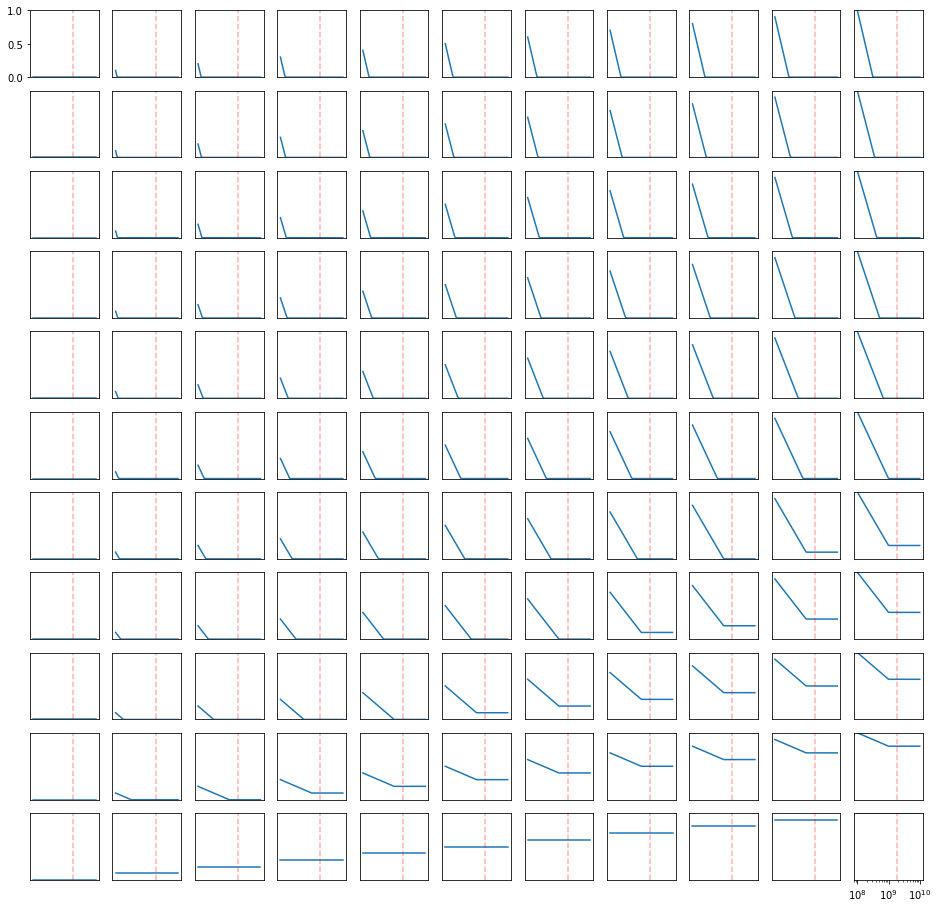

In [9]:
def plot_prob(x, m, b, cutoff):
    #return x*np.log10(m) + b
    #return -np.log10(x*m) + b
    #return -np.log10(x*m) + b # y=mx+b
    #return -np.log10(m * (x-1e8)) + b # linear equation given slope and one point, but with slope and x axis logged
    y = []
    for x_elt in x:
        if x_elt <= 1e8:
            y.append(b)
        elif (x_elt > 1e8) & (x_elt <= cutoff):
            y_elt = b + m*(np.log10(x_elt)-8)
            if y_elt < 0: # handle negative probabilities
                y_elt = 0
            elif y_elt > 1:
                y_elt = 1
            y.append(y_elt)
        elif x_elt > cutoff: # if star is older than cutoff, use P(intact) at cutoff time
            y_elt = b + m*(np.log10(cutoff)-8)
            if y_elt < 0: # handle negative probabilities
                y_elt = 0
            elif y_elt > 1:
                y_elt = 1
            y.append(y_elt) 
            
    return y

def plot_prob_wrong(x, m, b, cutoff):
    #return x*np.log10(m) + b
    #return -np.log10(x*m) + b
    #return -np.log10(x*m) + b # y=mx+b
    #return -np.log10(m * (x-1e8)) + b # linear equation given slope and one point, but with slope and x axis logged
    y = []
    for x_elt in x:
        if x_elt <= 1e8:
            y.append(b)
        elif (x_elt > 1e8) & (x_elt <= cutoff):
            y_elt = b + m*(np.log10(x_elt)-8)
            if y_elt < 0: # handle negative probabilities
                y_elt = 0
            elif y_elt > 1:
                y_elt = 1
            y.append(y_elt)
        elif x_elt > cutoff: # if star is older than cutoff, use P(intact) at cutoff time
            y_elt = b + m*(np.log10(cutoff))
            if y_elt < 0: # handle negative probabilities
                y_elt = 0
            elif y_elt > 1:
                y_elt = 1
            y.append(y_elt) 
            
    return y

x = np.logspace(8, 10, 100)
plt.figure(figsize=(16,16))
index = 0
ms = np.linspace(-2, 0, 11)
for i, gi_m in enumerate(ms):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (i,gi_b))
        #ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        #ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        
        #cube = [random.uniform(0,1), random.uniform(0,1)]
        #cube = prior_grid(cube, ndim, nparams, gi_m, gi_b)
        cutoff = 1e9 # placeholder
        
        #print(round(gi_m, 1), df.bs[index])
        y = plot_prob(x, round(gi_m, 1), df.bs[index], cutoff)
        #y = prob_intact(x, round(df.ms[index], 1), df.bs[index], cutoff)
        #y = prob_intact(x, np.linspace(-1,0,11)[gi_m], np.linspace(0,1,11)[gi_b])
        ax.plot(x, y)
        ax.set_ylim([0, 1])
        
        if index < 1:
            ax.get_yaxis().set_visible(True)
        else:
            ax.get_yaxis().set_visible(False)
        
        if index < 120:
            ax.get_xaxis().set_visible(False)
        else:
            ax.get_xaxis().set_visible(True)            

        ax.set_xscale('log')
        
        index += 1
        
        # plot vertical red line through median age of Berger FGK dwarfs
        ax.plot([1e9*np.median(berger_kepler.iso_age), 1e9*np.median(berger_kepler.iso_age)], 
                [0,1], color='r', alpha=0.3, linestyle='--')

#plt.savefig('models.eps', format='eps')
plt.show()

#### Scaling of 0.1

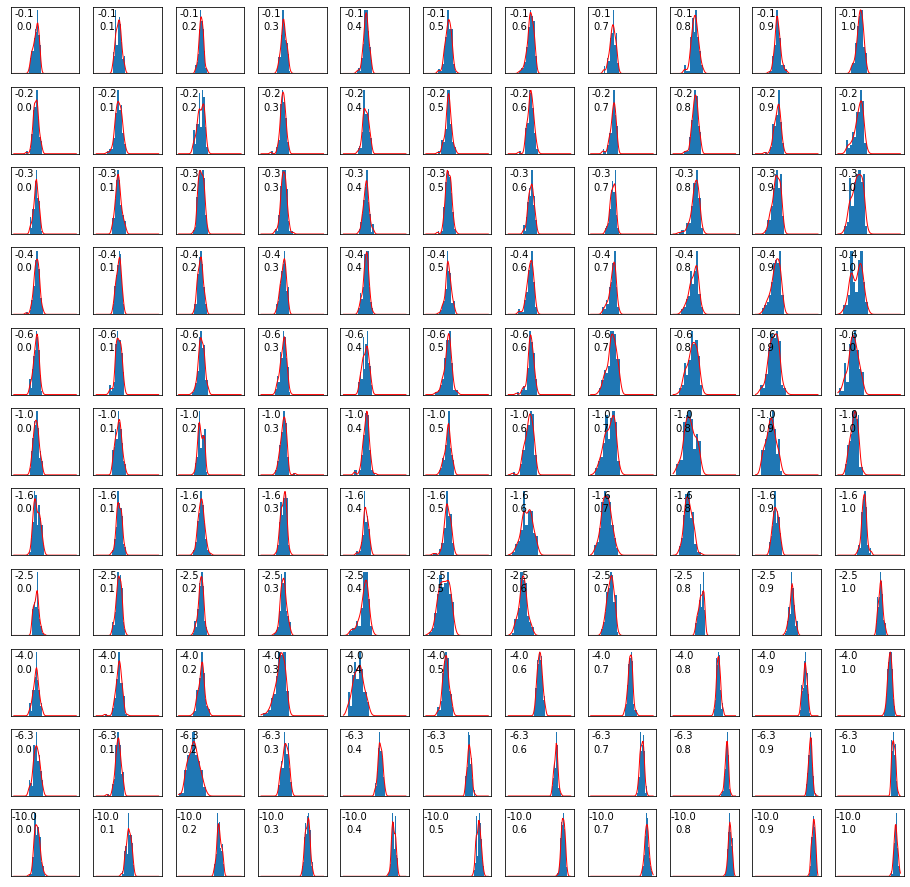

In [10]:
def kde_func(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    kde = gaussian_kde(x) # constant bandwidth so imbalance in sample size doesn't drive distribution
    return kde.evaluate(x_grid)

def prior_grid(cube, ndim, nparams, gi_m, gi_b):
    """
    Each model run will use an evenly spaced (m,b) tuple on a discrete 11x11 grid
    Does that ruin the point of multinest? Is it valid without random sampling? 
    Maybe so, but pymultinest keeps getting stuck, so I need to get a better sense of the logL surface.
    gi_m: grid index on m axis
    gi_b: grid index on b axis
    """
    cube[0] = np.linspace(-1,0,11)[gi_m]
    cube[1] = np.linspace(0,1,11)[gi_b]
    return cube

def generate_rand_from_pdf(pdf, x_grid, n):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(n) 
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    return random_from_cdf

def kde(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    #kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=0)) # ddof=1 means std divisor is N-1 instead of N
    #kde = gaussian_kde(x, bw_method=np.power(len(x), -0.2)) # ddof=1 means std divisor is N-1 instead of N
    kde = gaussian_kde(x, bw_method=0.15) # constant bandwidth so imbalance in sample size doesn't drive distribution
    #print(bandwidth/x.std(ddof=1)) # this is bw used in S/O
    #print(np.power(len(x), -0.2)) # the bw if I use Scott's factor as the bw to multiply with covariance matrix
    return kde.evaluate(x_grid)

plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 10
nparams = 2
draws = 50
logLs = df_ten_billion.logLs_nonzero2
lams = df_ten_billion.lams_nonzero2
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
bs = df_billion.bs
ms = ms_corrected
peak_logLs = []
mean_logLs = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        # top text is timescale for going from P(intact)=1 to P(intact)=0
        ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        peak_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
        
#plt.savefig('logLs.eps', format='eps')
plt.show()

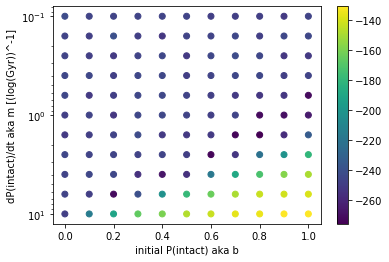

In [11]:
plt.scatter(bs, [-1*m for m in ms_corrected], c=peak_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [(log(Gyr))^-1]')
plt.gca().invert_yaxis()
#plt.yscale('symlog', linthreshy=10)
plt.yscale('log')
plt.colorbar()
plt.show()

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/numpy/core/_methods.py:163: UserWarning: Warning: converting a masked element to nan.
  arr = asanyarray(a)
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/numpy/ma/core.py:2830: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/numpy/ma/core.py:2361: UserWarning: Warning: converting a masked element to nan.
  a = np.array(a, copy=copy, subok=True)


[75.5, 6.1000000000000005, masked, masked, masked] [62.2, 2.9000000000000004, masked, masked, masked] [68.465, 4.6259999999999994, nan, nan, nan]


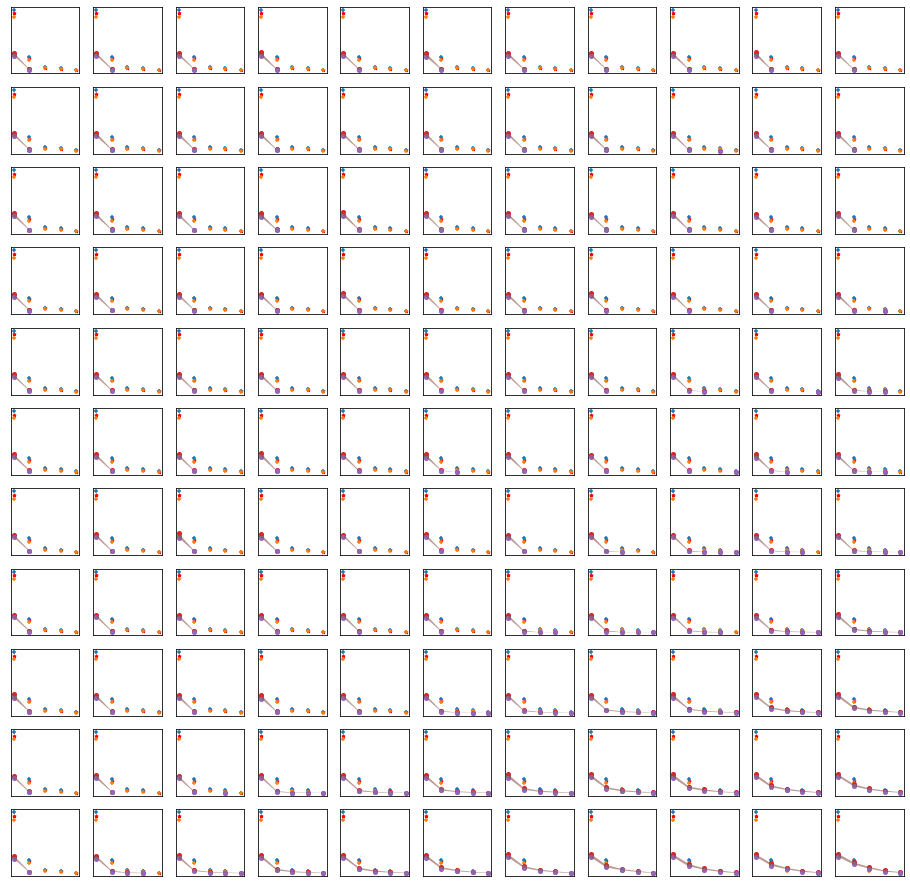

In [12]:
from itertools import zip_longest
import numpy.ma as ma # for masked arrays

plt.figure(figsize=(16,16))
index = 0
nonzero_k = k[1:]

#short_k = k*1000/np.sum(k)
lam_upper = []
lam_lower = []
lam_avgs = []
for gi_m in range(11):
    for gi_b in range(11):
        # avg, max, and min transit multiplicities to compare against data
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        lam_elt = lams[index]
        lam_elt_max = []
        lam_elt_min = []
        lam_elt_avg = []
        for temp_list in zip_longest(*lam_elt):
            elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
            lam_elt_max.append(max(elt))
            lam_elt_min.append(min(elt))
            lam_elt_avg.append(np.mean(elt))
        if index==0:
            print(lam_elt_max, lam_elt_min, lam_elt_avg)
        
        lam_upper.append(lam_elt_max)
        lam_lower.append(lam_elt_min)
        lam_avgs.append(lam_elt_avg)

        # plotting
        ax.scatter(np.arange(5), nonzero_k, marker=(5, 1), color='r', s=10)
        ax.scatter(np.arange(5), nonzero_k+np.sqrt(nonzero_k), marker='+', s=10)
        ax.scatter(np.arange(5), nonzero_k-np.sqrt(nonzero_k), marker='+', s=10)
        ax.scatter(np.arange(5), lam_elt_avg, s=16)
        ax.scatter(np.arange(5), lam_elt_max, s=16)
        ax.scatter(np.arange(5), lam_elt_min, s=16)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        #ax.set_ylim([0, 30])
        
        # draw envelope
        ax.fill_between(np.arange(len(lam_elt_min)), lam_elt_min, lam_elt_max, alpha=0.6)

        index += 1
plt.show()

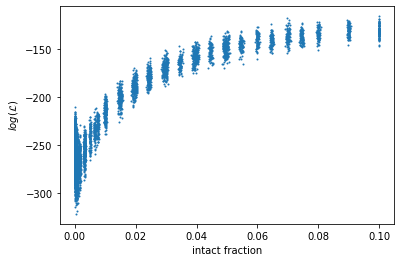

In [39]:
plt.scatter(0.1*df_ten_billion.intact_fracs.explode(), df_ten_billion.logLs_nonzero2.explode(), s=1)
plt.ylabel(r'$log(\mathcal{L})$')
plt.xlabel('intact fraction')
#plt.xlim(0, 0.4)
#plt.ylim(-300, -120)
#plt.savefig('logLs_v_intacts_nonbinned.eps', format='eps')
plt.show()

#### Note! In future simulations, intact_frac will be split among scaling factors so that we don't have to adjust on an ad hoc basis like above. Also, filtering conditions below to plot best models per scaling factor use pre-scaling-factor-adjusted intact fractions, again, because we didn't create specific intact_frac columns per scaling model.

In [69]:
# df_exploded = df_ten_billion.apply(pd.Series.explode) # looks like it doesn't do so correctly for geometric cols but does't matter
df_exploded1 = df_exploded.loc[(df_exploded.logLs_nonzero2 > -460) & (df_exploded.intact_fracs > 0.85) 
                             & (df_exploded.intact_fracs < 0.95)]
print(np.mean(0.1*df_exploded1.intact_fracs), np.mean(df_exploded1.logLs_nonzero2))
print(len(df_exploded1)) # good, at least all three models that fall in this clump do so entirely
print(np.min(df_exploded1.logLs_nonzero2))

0.08997801592468324 -130.82442382200804
100
-145.84846217944425


[82.10000000000001, 42.400000000000006, 23.0, 11.4, 4.0] [71.2, 32.5, 16.8, 6.0, 1.6] [77.153, 38.13400000000001, 20.328000000000003, 8.868, 2.781]


[]

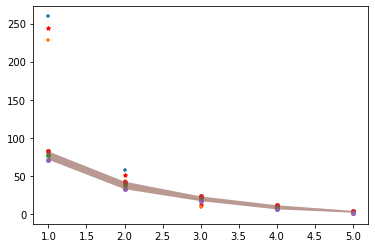

In [15]:
lam_upper = []
lam_lower = []
lam_avgs = []
lams_nonzero = [ln for ln in df_exploded1.lams_nonzero2]
for temp_list in zip_longest(*lams_nonzero):
    #elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
    lam_upper.append(max(temp_list))
    lam_lower.append(min(temp_list))
    lam_avgs.append(np.mean(temp_list))
print(lam_upper, lam_lower, lam_avgs)

plt.scatter(np.arange(6)[1:], nonzero_k, marker=(5, 1), color='r', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k+np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k-np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], lam_avgs, s=16)
plt.scatter(np.arange(6)[1:], lam_upper, s=16)
plt.scatter(np.arange(6)[1:], lam_lower, s=16)
plt.fill_between(np.arange(6)[1:], lam_lower, lam_upper, alpha=0.6)
plt.plot()

#### Scaling of 0.2

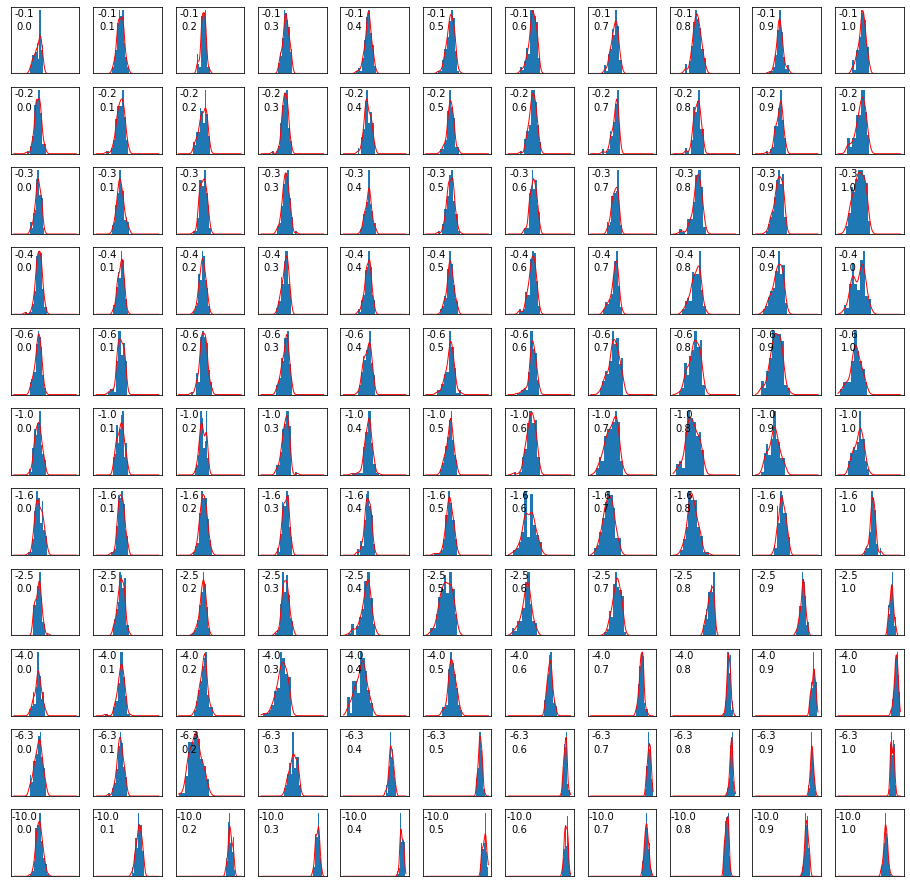

In [51]:
plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 10
nparams = 2
draws = 50
logLs = df_ten_billion.logLs_nonzero3
lams = df_ten_billion.lams_nonzero3
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
bs = df_billion.bs
ms = ms_corrected
peak_logLs = []
mean_logLs = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        # top text is timescale for going from P(intact)=1 to P(intact)=0
        ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        peak_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
        
#plt.savefig('logLs.eps', format='eps')
plt.show()

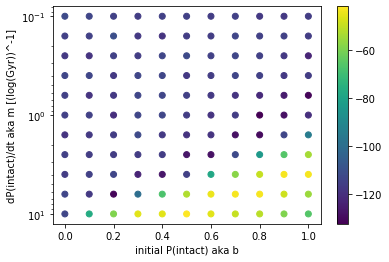

In [52]:
plt.scatter(bs, [-1*m for m in ms_corrected], c=peak_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [(log(Gyr))^-1]')
plt.gca().invert_yaxis()
#plt.yscale('symlog', linthreshy=10)
plt.yscale('log')
plt.colorbar()
plt.show()

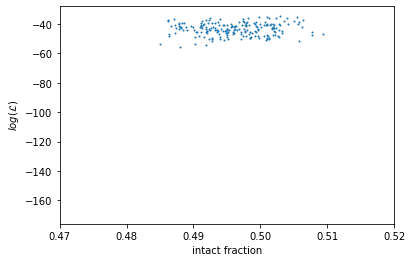

In [93]:
plt.scatter(df_ten_billion.intact_fracs.explode(), df_ten_billion.logLs_nonzero3.explode(), s=1)
plt.ylabel(r'$log(\mathcal{L})$')
plt.xlabel('intact fraction')
plt.xlim(0.47, 0.52)
#plt.ylim(-60, -30)
#plt.savefig('logLs_v_intacts_nonbinned.eps', format='eps')
plt.show()

In [95]:
df_exploded = df_ten_billion.apply(pd.Series.explode) # looks like it doesn't do so correctly for geometric cols but does't matter
df_exploded1 = df_exploded.loc[(df_exploded.logLs_nonzero6 > -460) & (0.2*df_exploded.intact_fracs > 0.095) 
                             & (0.2*df_exploded.intact_fracs < 0.105)]
print(np.mean(0.2*df_exploded1.intact_fracs), np.mean(df_exploded1.logLs_nonzero3))
print(len(df_exploded1)) # good, at least all three models that fall in this clump do so entirely
print(np.min(df_exploded1.logLs_nonzero6))

0.0992281035605188 -43.54040610654465
200
-115.0963815646512


In [94]:
df_exploded = df_ten_billion.apply(pd.Series.explode) # looks like it doesn't do so correctly for geometric cols but does't matter
df_exploded1 = df_exploded.loc[(df_exploded.logLs_nonzero6 > -460) & (df_exploded.intact_fracs > 0.47) 
                             & (df_exploded.intact_fracs < 0.52)]
print(np.mean(0.2*df_exploded1.intact_fracs), np.mean(df_exploded1.logLs_nonzero3))
print(len(df_exploded1)) # good, at least all three models that fall in this clump do so entirely
print(np.min(df_exploded1.logLs_nonzero6))

0.0992281035605188 -43.54040610654465
200
-115.0963815646512


[159.60000000000002, 52.6, 27.0, 15.0, 4.6000000000000005] [132.8, 37.2, 16.8, 6.6000000000000005, 1.0] [146.042, 45.69200000000001, 22.216000000000005, 9.677999999999999, 2.903]


[]

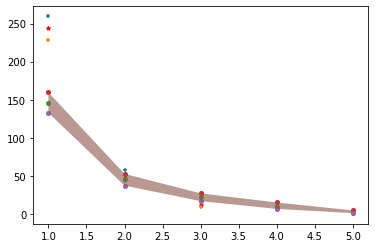

In [63]:
lam_upper = []
lam_lower = []
lam_avgs = []
lams_nonzero = [ln for ln in df_exploded1.lams_nonzero3]
for temp_list in zip_longest(*lams_nonzero):
    #elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
    lam_upper.append(max(temp_list))
    lam_lower.append(min(temp_list))
    lam_avgs.append(np.mean(temp_list))
print(lam_upper, lam_lower, lam_avgs)

plt.scatter(np.arange(6)[1:], nonzero_k, marker=(5, 1), color='r', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k+np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k-np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], lam_avgs, s=16)
plt.scatter(np.arange(6)[1:], lam_upper, s=16)
plt.scatter(np.arange(6)[1:], lam_lower, s=16)
plt.fill_between(np.arange(6)[1:], lam_lower, lam_upper, alpha=0.6)
plt.plot()

#### Scaling of 0.3

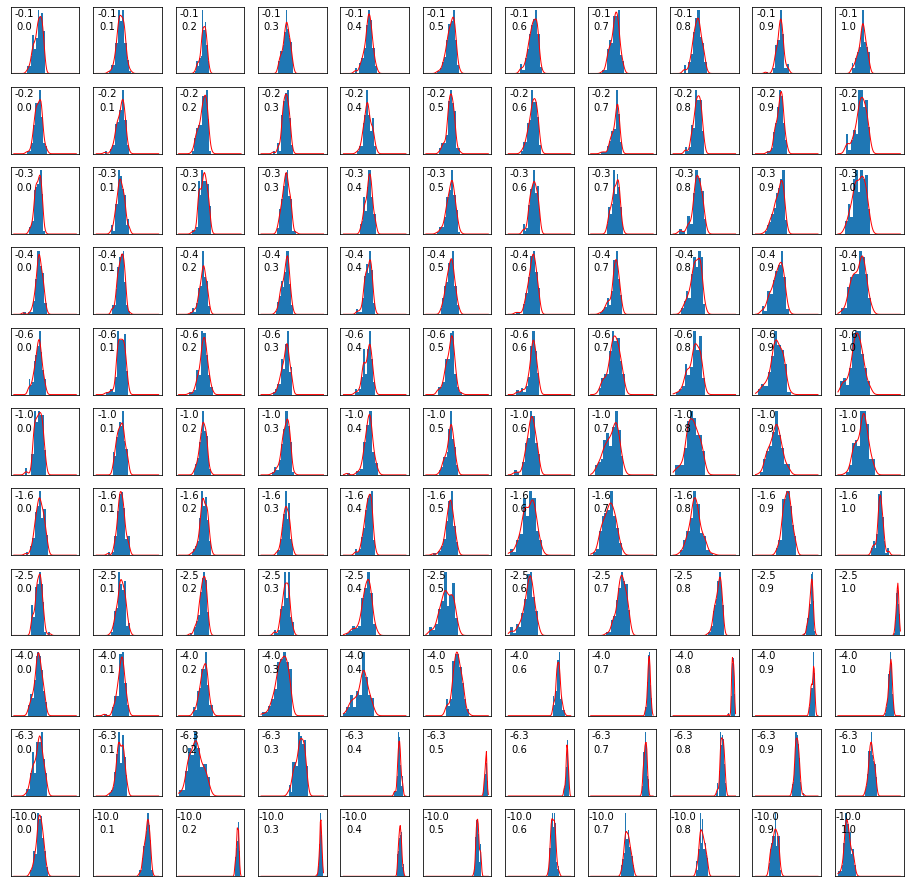

In [33]:
plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 10
nparams = 2
draws = 50
logLs = df_ten_billion.logLs_nonzero4
lams = df_ten_billion.lams_nonzero4
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
bs = df_billion.bs
ms = ms_corrected
peak_logLs = []
mean_logLs = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        # top text is timescale for going from P(intact)=1 to P(intact)=0
        ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        peak_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
        
#plt.savefig('logLs.eps', format='eps')
plt.show()

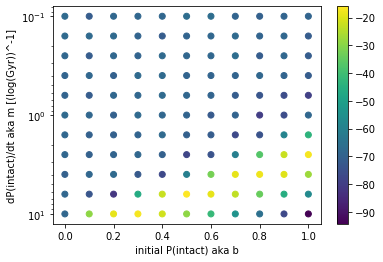

In [34]:
plt.scatter(bs, [-1*m for m in ms_corrected], c=peak_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [(log(Gyr))^-1]')
plt.gca().invert_yaxis()
#plt.yscale('symlog', linthreshy=10)
plt.yscale('log')
plt.colorbar()
plt.show()

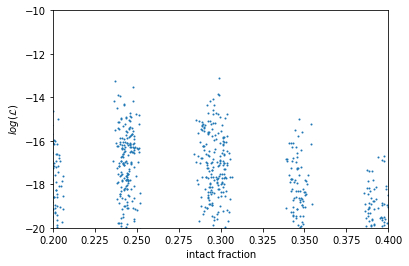

In [86]:
plt.scatter(df_ten_billion.intact_fracs.explode(), df_ten_billion.logLs_nonzero4.explode(), s=1)
plt.ylabel(r'$log(\mathcal{L})$')
plt.xlabel('intact fraction')
plt.xlim(0.2, 0.4)
plt.ylim(-20, -10)
#plt.savefig('logLs_v_intacts_nonbinned.eps', format='eps')
plt.show()

In [84]:
df_exploded = df_ten_billion.apply(pd.Series.explode) # looks like it doesn't do so correctly for geometric cols but does't matter
df_exploded1 = df_exploded.loc[(df_exploded.logLs_nonzero6 > -460) & (df_exploded.intact_fracs > 0.275) 
                             & (df_exploded.intact_fracs < 0.325)]
print(np.mean(0.3*df_exploded1.intact_fracs), np.mean(df_exploded1.logLs_nonzero6))
print(len(df_exploded1)) # good, at least all three models that fall in this clump do so entirely
print(np.min(df_exploded1.logLs_nonzero6))

0.08885199559316942 -49.70272091177855
200
-68.66987942757181


[380.0, 54.0, 17.0, 10.0, 4.0] [311.5, 31.0, 5.0, 1.0, 0.0] [347.3775, 41.375, 11.0075, 4.725, 1.515]


[]

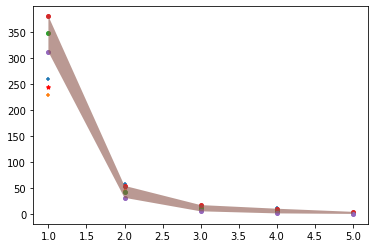

In [37]:
lam_upper = []
lam_lower = []
lam_avgs = []
lams_nonzero = [ln for ln in df_exploded1.lams_nonzero6]
for temp_list in zip_longest(*lams_nonzero):
    #elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
    lam_upper.append(max(temp_list))
    lam_lower.append(min(temp_list))
    lam_avgs.append(np.mean(temp_list))
print(lam_upper, lam_lower, lam_avgs)

plt.scatter(np.arange(6)[1:], nonzero_k, marker=(5, 1), color='r', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k+np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k-np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], lam_avgs, s=16)
plt.scatter(np.arange(6)[1:], lam_upper, s=16)
plt.scatter(np.arange(6)[1:], lam_lower, s=16)
plt.fill_between(np.arange(6)[1:], lam_lower, lam_upper, alpha=0.6)
plt.plot()

#### Scaling of 0.4

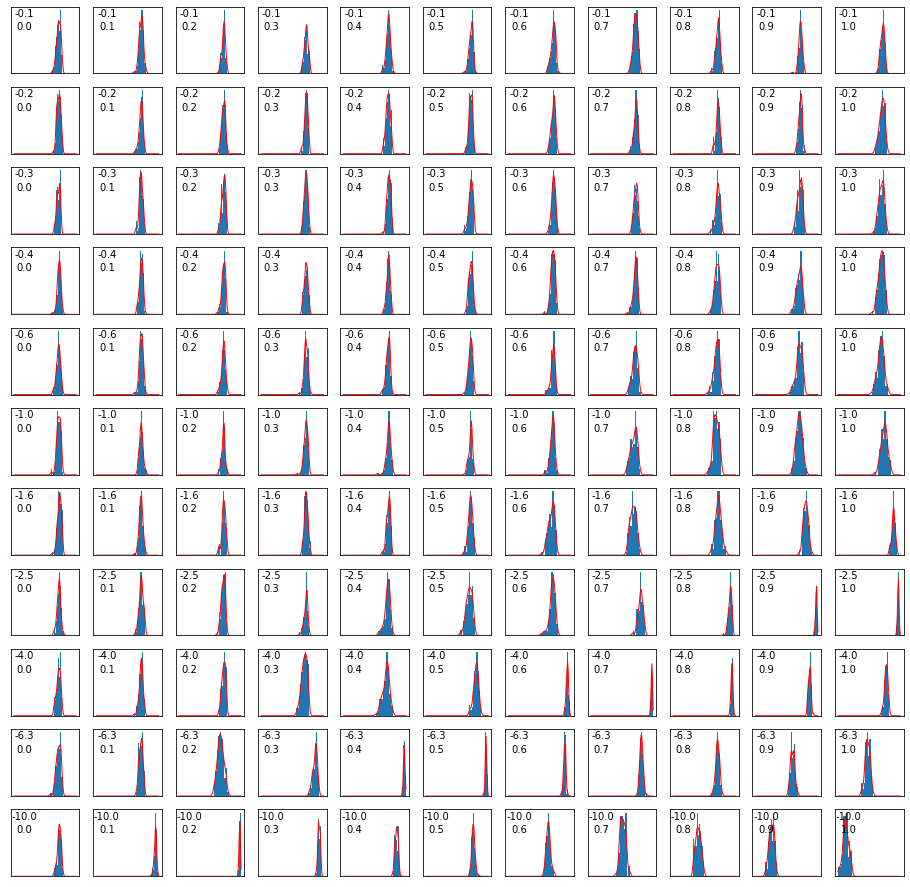

In [16]:
def kde_func(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    kde = gaussian_kde(x) # constant bandwidth so imbalance in sample size doesn't drive distribution
    return kde.evaluate(x_grid)

def prior_grid(cube, ndim, nparams, gi_m, gi_b):
    """
    Each model run will use an evenly spaced (m,b) tuple on a discrete 11x11 grid
    Does that ruin the point of multinest? Is it valid without random sampling? 
    Maybe so, but pymultinest keeps getting stuck, so I need to get a better sense of the logL surface.
    gi_m: grid index on m axis
    gi_b: grid index on b axis
    """
    cube[0] = np.linspace(-1,0,11)[gi_m]
    cube[1] = np.linspace(0,1,11)[gi_b]
    return cube

def generate_rand_from_pdf(pdf, x_grid, n):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(n) 
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    return random_from_cdf

def kde(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    #kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=0)) # ddof=1 means std divisor is N-1 instead of N
    #kde = gaussian_kde(x, bw_method=np.power(len(x), -0.2)) # ddof=1 means std divisor is N-1 instead of N
    kde = gaussian_kde(x, bw_method=0.15) # constant bandwidth so imbalance in sample size doesn't drive distribution
    #print(bandwidth/x.std(ddof=1)) # this is bw used in S/O
    #print(np.power(len(x), -0.2)) # the bw if I use Scott's factor as the bw to multiply with covariance matrix
    return kde.evaluate(x_grid)

plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 10
nparams = 2
draws = 50
logLs = df_ten_billion.logLs_nonzero5
lams = df_ten_billion.lams_nonzero5
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
bs = df_billion.bs
ms = ms_corrected
peak_logLs = []
mean_logLs = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        # top text is timescale for going from P(intact)=1 to P(intact)=0
        ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        peak_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
        
#plt.savefig('logLs.eps', format='eps')
plt.show()

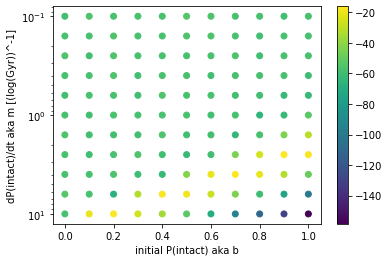

In [17]:
plt.scatter(bs, [-1*m for m in ms_corrected], c=peak_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [(log(Gyr))^-1]')
plt.gca().invert_yaxis()
#plt.yscale('symlog', linthreshy=10)
plt.yscale('log')
plt.colorbar()
plt.show()

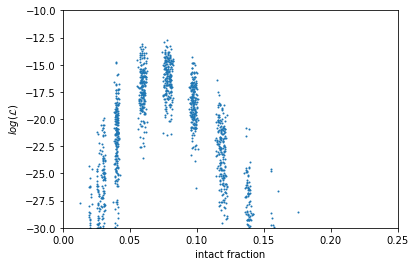

In [64]:
plt.scatter(0.4*df_ten_billion.intact_fracs.explode(), df_ten_billion.logLs_nonzero5.explode(), s=1)
plt.ylabel(r'$log(\mathcal{L})$')
plt.xlabel('intact fraction')
plt.xlim(0, 0.25)
plt.ylim(-30, -10)
#plt.savefig('logLs_v_intacts_nonbinned.eps', format='eps')
plt.show()

In [72]:
df_exploded = df_ten_billion.apply(pd.Series.explode) # looks like it doesn't do so correctly for geometric cols but does't matter
df_exploded1 = df_exploded.loc[(df_exploded.logLs_nonzero5 > -460) & (df_exploded.intact_fracs > 0.17) 
                             & (df_exploded.intact_fracs < 0.23)]
print(np.mean(0.4*df_exploded1.intact_fracs), np.mean(df_exploded1.logLs_nonzero5))
print(len(df_exploded1)) # good, at least all three models that fall in this clump do so entirely
print(np.min(df_exploded1.logLs_nonzero5))

0.07828273824427862 -16.283741398342077
200
-21.50802737665827


[309.6, 56.0, 23.6, 12.4, 6.0] [254.8, 37.6, 10.4, 4.0, 0.4] [278.67400000000004, 46.95800000000001, 17.252, 7.752000000000001, 2.3280000000000003]


[]

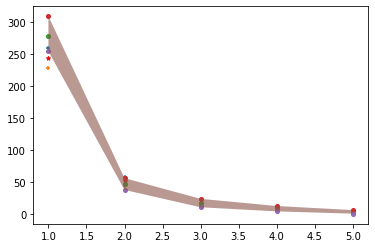

In [20]:
lam_upper = []
lam_lower = []
lam_avgs = []
lams_nonzero = [ln for ln in df_exploded1.lams_nonzero5]
for temp_list in zip_longest(*lams_nonzero):
    #elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
    lam_upper.append(max(temp_list))
    lam_lower.append(min(temp_list))
    lam_avgs.append(np.mean(temp_list))
print(lam_upper, lam_lower, lam_avgs)

plt.scatter(np.arange(6)[1:], nonzero_k, marker=(5, 1), color='r', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k+np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k-np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], lam_avgs, s=16)
plt.scatter(np.arange(6)[1:], lam_upper, s=16)
plt.scatter(np.arange(6)[1:], lam_lower, s=16)
plt.fill_between(np.arange(6)[1:], lam_lower, lam_upper, alpha=0.6)
plt.plot()

#### Scaling of 0.5

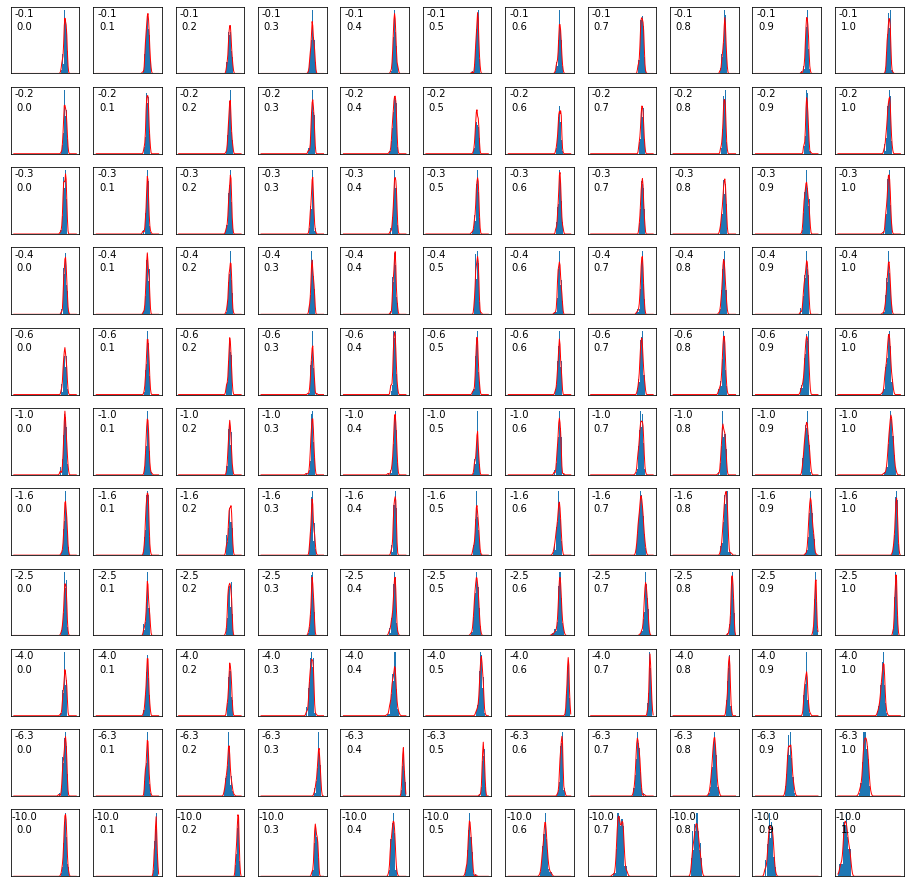

In [28]:
plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 10
nparams = 2
draws = 50
logLs = df_ten_billion.logLs_nonzero6
lams = df_ten_billion.lams_nonzero6
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
bs = df_billion.bs
ms = ms_corrected
peak_logLs = []
mean_logLs = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        # top text is timescale for going from P(intact)=1 to P(intact)=0
        ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        peak_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
        
#plt.savefig('logLs.eps', format='eps')
plt.show()

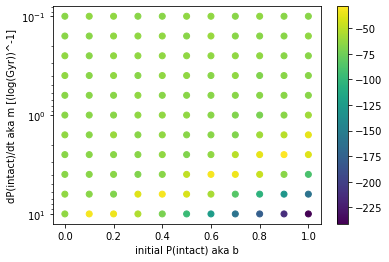

In [29]:
plt.scatter(bs, [-1*m for m in ms_corrected], c=peak_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [(log(Gyr))^-1]')
plt.gca().invert_yaxis()
#plt.yscale('symlog', linthreshy=10)
plt.yscale('log')
plt.colorbar()
plt.show()

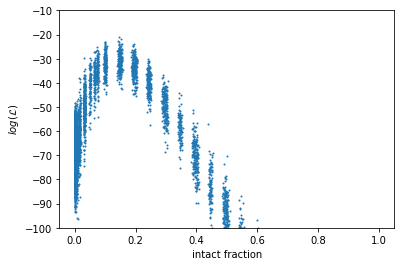

In [76]:
plt.scatter(df_ten_billion.intact_fracs.explode(), df_ten_billion.logLs_nonzero6.explode(), s=1)
plt.ylabel(r'$log(\mathcal{L})$')
plt.xlabel('intact fraction')
#plt.xlim(0.05, 0.11)
plt.ylim(-100, -10)
#plt.savefig('logLs_v_intacts_nonbinned.eps', format='eps')
plt.show()

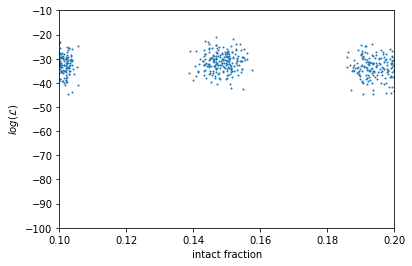

In [100]:
plt.scatter(df_ten_billion.intact_fracs.explode(), df_ten_billion.logLs_nonzero6.explode(), s=1)
plt.ylabel(r'$log(\mathcal{L})$')
plt.xlabel('intact fraction')
plt.xlim(0.1, 0.2)
plt.ylim(-100, -10)
#plt.savefig('logLs_v_intacts_nonbinned.eps', format='eps')
plt.show()

In [101]:
df_exploded = df_ten_billion.apply(pd.Series.explode) # looks like it doesn't do so correctly for geometric cols but does't matter
df_exploded1 = df_exploded.loc[(df_exploded.logLs_nonzero6 > -460) & (df_exploded.intact_fracs > 0.13) 
                             & (df_exploded.intact_fracs < 0.17)]
print(np.mean(0.5*df_exploded1.intact_fracs), np.mean(df_exploded1.logLs_nonzero6))
print(len(df_exploded1)) # good, at least all three models that fall in this clump do so entirely
print(np.min(df_exploded1.logLs_nonzero6))

0.0741872402223446 -31.36857417770235
200
-42.5888666593007


[380.0, 54.0, 17.0, 10.0, 4.0] [311.5, 31.0, 5.0, 1.0, 0.0] [347.3775, 41.375, 11.0075, 4.725, 1.515]


[]

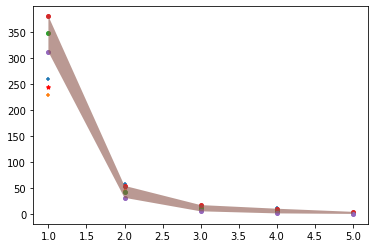

In [32]:
lam_upper = []
lam_lower = []
lam_avgs = []
lams_nonzero = [ln for ln in df_exploded1.lams_nonzero6]
for temp_list in zip_longest(*lams_nonzero):
    #elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
    lam_upper.append(max(temp_list))
    lam_lower.append(min(temp_list))
    lam_avgs.append(np.mean(temp_list))
print(lam_upper, lam_lower, lam_avgs)

plt.scatter(np.arange(6)[1:], nonzero_k, marker=(5, 1), color='r', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k+np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k-np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], lam_avgs, s=16)
plt.scatter(np.arange(6)[1:], lam_upper, s=16)
plt.scatter(np.arange(6)[1:], lam_lower, s=16)
plt.fill_between(np.arange(6)[1:], lam_lower, lam_upper, alpha=0.6)
plt.plot()

#### Scaling of 0.6

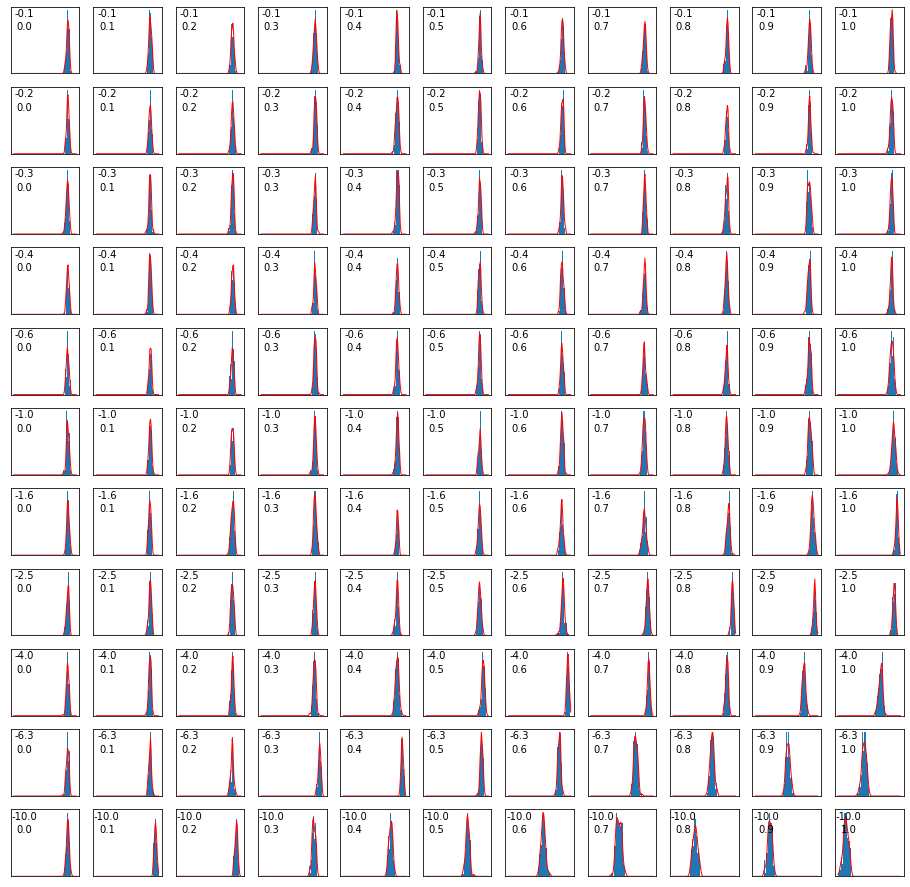

In [21]:
def kde_func(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    kde = gaussian_kde(x) # constant bandwidth so imbalance in sample size doesn't drive distribution
    return kde.evaluate(x_grid)

def prior_grid(cube, ndim, nparams, gi_m, gi_b):
    """
    Each model run will use an evenly spaced (m,b) tuple on a discrete 11x11 grid
    Does that ruin the point of multinest? Is it valid without random sampling? 
    Maybe so, but pymultinest keeps getting stuck, so I need to get a better sense of the logL surface.
    gi_m: grid index on m axis
    gi_b: grid index on b axis
    """
    cube[0] = np.linspace(-1,0,11)[gi_m]
    cube[1] = np.linspace(0,1,11)[gi_b]
    return cube

def generate_rand_from_pdf(pdf, x_grid, n):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(n) 
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    return random_from_cdf

def kde(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    #kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=0)) # ddof=1 means std divisor is N-1 instead of N
    #kde = gaussian_kde(x, bw_method=np.power(len(x), -0.2)) # ddof=1 means std divisor is N-1 instead of N
    kde = gaussian_kde(x, bw_method=0.15) # constant bandwidth so imbalance in sample size doesn't drive distribution
    #print(bandwidth/x.std(ddof=1)) # this is bw used in S/O
    #print(np.power(len(x), -0.2)) # the bw if I use Scott's factor as the bw to multiply with covariance matrix
    return kde.evaluate(x_grid)

plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 10
nparams = 2
draws = 50
logLs = df_ten_billion.logLs_nonzero7
lams = df_ten_billion.lams_nonzero7
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
bs = df_billion.bs
ms = ms_corrected
peak_logLs = []
mean_logLs = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        # top text is timescale for going from P(intact)=1 to P(intact)=0
        ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        peak_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
        
#plt.savefig('logLs.eps', format='eps')
plt.show()

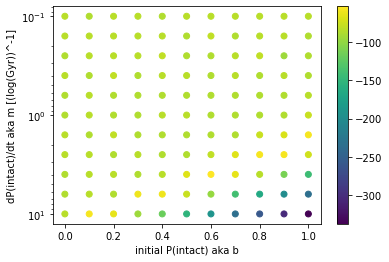

In [22]:
plt.scatter(bs, [-1*m for m in ms_corrected], c=peak_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [(log(Gyr))^-1]')
plt.gca().invert_yaxis()
#plt.yscale('symlog', linthreshy=10)
plt.yscale('log')
plt.colorbar()
plt.show()

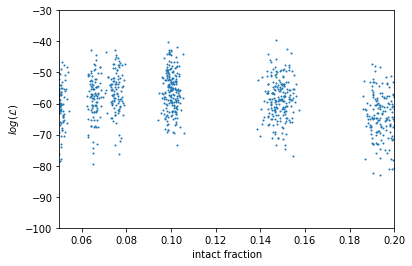

In [105]:
plt.scatter(df_ten_billion.intact_fracs.explode(), df_ten_billion.logLs_nonzero7.explode(), s=1)
plt.ylabel(r'$log(\mathcal{L})$')
plt.xlabel('intact fraction')
plt.xlim(0.05, 0.2)
plt.ylim(-100, -30)
#plt.savefig('logLs_v_intacts_nonbinned.eps', format='eps')
plt.show()

In [106]:
df_exploded = df_ten_billion.apply(pd.Series.explode) # looks like it doesn't do so correctly for geometric cols but does't matter
df_exploded1 = df_exploded.loc[(df_exploded.logLs_nonzero7 > -460) & (df_exploded.intact_fracs > 0.09) 
                             & (df_exploded.intact_fracs < 0.11)]
print(np.mean(0.6*df_exploded1.intact_fracs), np.mean(df_exploded1.logLs_nonzero7))
print(len(df_exploded1)) # good, at least all three models that fall in this clump do so entirely
print(np.min(df_exploded1.logLs_nonzero7))

0.06009750112674646 -55.91816106470205
200
-73.27318948583024


In [25]:
print(len(df_exploded), len(df_ten_billion))

12100 121


[456.0, 64.80000000000001, 20.400000000000002, 12.0, 4.800000000000001] [373.8, 37.2, 6.0, 1.2000000000000002, 0.0] [416.853, 49.65, 13.209000000000001, 5.67, 1.818]


[]

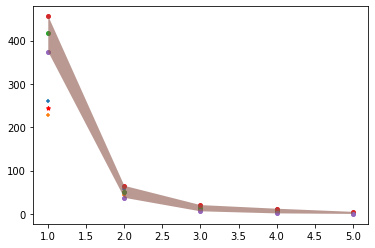

In [107]:
lam_upper = []
lam_lower = []
lam_avgs = []
lams_nonzero = [ln for ln in df_exploded1.lams_nonzero7]
for temp_list in zip_longest(*lams_nonzero):
    #elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
    lam_upper.append(max(temp_list))
    lam_lower.append(min(temp_list))
    lam_avgs.append(np.mean(temp_list))
print(lam_upper, lam_lower, lam_avgs)

plt.scatter(np.arange(6)[1:], nonzero_k, marker=(5, 1), color='r', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k+np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k-np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], lam_avgs, s=16)
plt.scatter(np.arange(6)[1:], lam_upper, s=16)
plt.scatter(np.arange(6)[1:], lam_lower, s=16)
plt.fill_between(np.arange(6)[1:], lam_lower, lam_upper, alpha=0.6)
plt.plot()

#### Scaling of 0.7

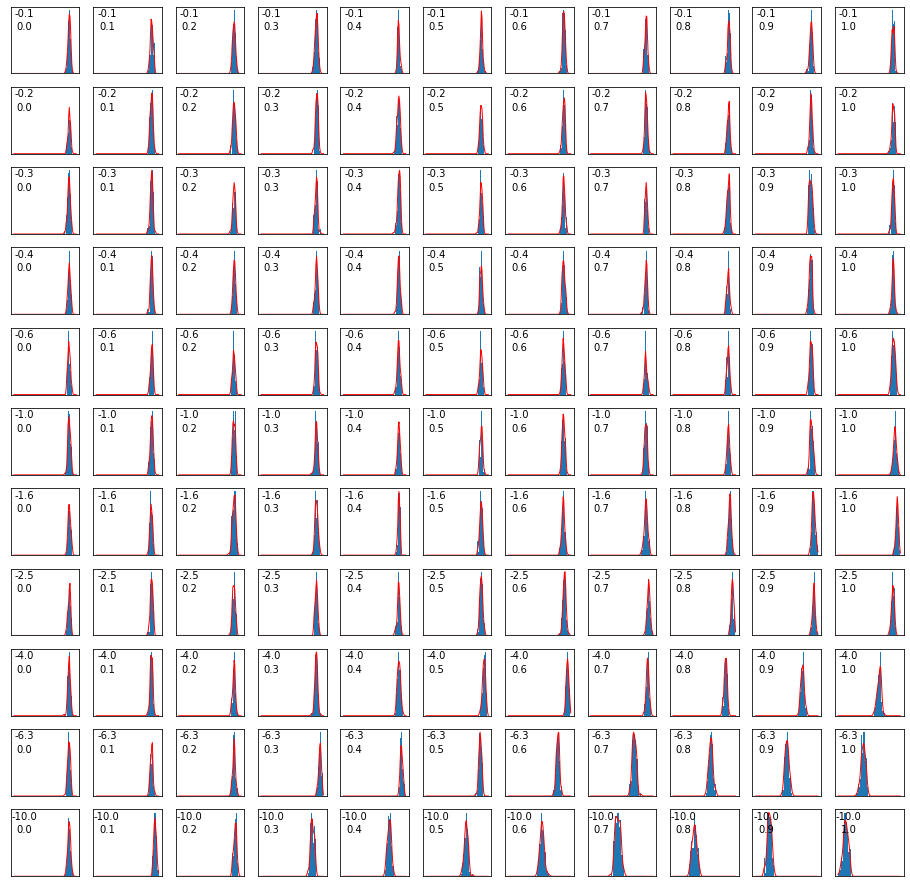

In [108]:
plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 10
nparams = 2
draws = 50
logLs = df_ten_billion.logLs_nonzero8
lams = df_ten_billion.lams_nonzero8
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
bs = df_billion.bs
ms = ms_corrected
peak_logLs = []
mean_logLs = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        # top text is timescale for going from P(intact)=1 to P(intact)=0
        ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        peak_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
        
#plt.savefig('logLs.eps', format='eps')
plt.show()

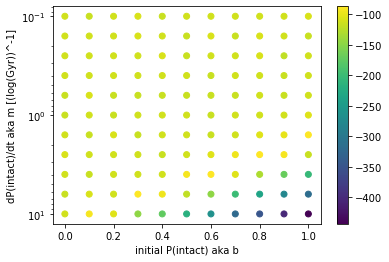

In [109]:
plt.scatter(bs, [-1*m for m in ms_corrected], c=peak_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [(log(Gyr))^-1]')
plt.gca().invert_yaxis()
#plt.yscale('symlog', linthreshy=10)
plt.yscale('log')
plt.colorbar()
plt.show()

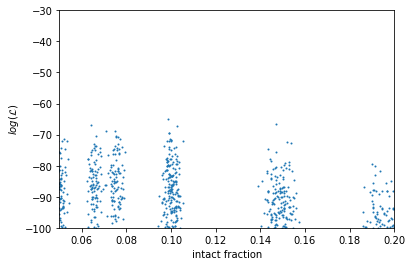

In [113]:
plt.scatter(df_ten_billion.intact_fracs.explode(), df_ten_billion.logLs_nonzero8.explode(), s=1)
plt.ylabel(r'$log(\mathcal{L})$')
plt.xlabel('intact fraction')
plt.xlim(0.05, 0.2)
plt.ylim(-100, -30)
#plt.savefig('logLs_v_intacts_nonbinned.eps', format='eps')
plt.show()

In [114]:
df_exploded = df_ten_billion.apply(pd.Series.explode) # looks like it doesn't do so correctly for geometric cols but does't matter
df_exploded1 = df_exploded.loc[(df_exploded.logLs_nonzero8 > -460) & (df_exploded.intact_fracs > 0.09) 
                             & (df_exploded.intact_fracs < 0.11)]
print(np.mean(0.7*df_exploded1.intact_fracs), np.mean(df_exploded1.logLs_nonzero8))
print(len(df_exploded1)) # good, at least all three models that fall in this clump do so entirely
print(np.min(df_exploded1.logLs_nonzero8))

0.07011375131453754 -88.4119415130824
200
-110.9615746604167


[532.0, 75.60000000000001, 23.800000000000004, 14.0, 5.6000000000000005] [436.1, 43.4, 7.0, 1.4000000000000001, 0.0] [486.32849999999996, 57.925, 15.410500000000003, 6.615, 2.1210000000000004]


[]

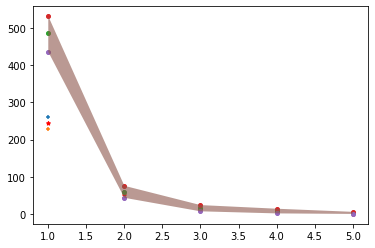

In [115]:
lam_upper = []
lam_lower = []
lam_avgs = []
lams_nonzero = [ln for ln in df_exploded1.lams_nonzero8]
for temp_list in zip_longest(*lams_nonzero):
    #elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
    lam_upper.append(max(temp_list))
    lam_lower.append(min(temp_list))
    lam_avgs.append(np.mean(temp_list))
print(lam_upper, lam_lower, lam_avgs)

plt.scatter(np.arange(6)[1:], nonzero_k, marker=(5, 1), color='r', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k+np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k-np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], lam_avgs, s=16)
plt.scatter(np.arange(6)[1:], lam_upper, s=16)
plt.scatter(np.arange(6)[1:], lam_lower, s=16)
plt.fill_between(np.arange(6)[1:], lam_lower, lam_upper, alpha=0.6)
plt.plot()

#### Scaling of 0.8

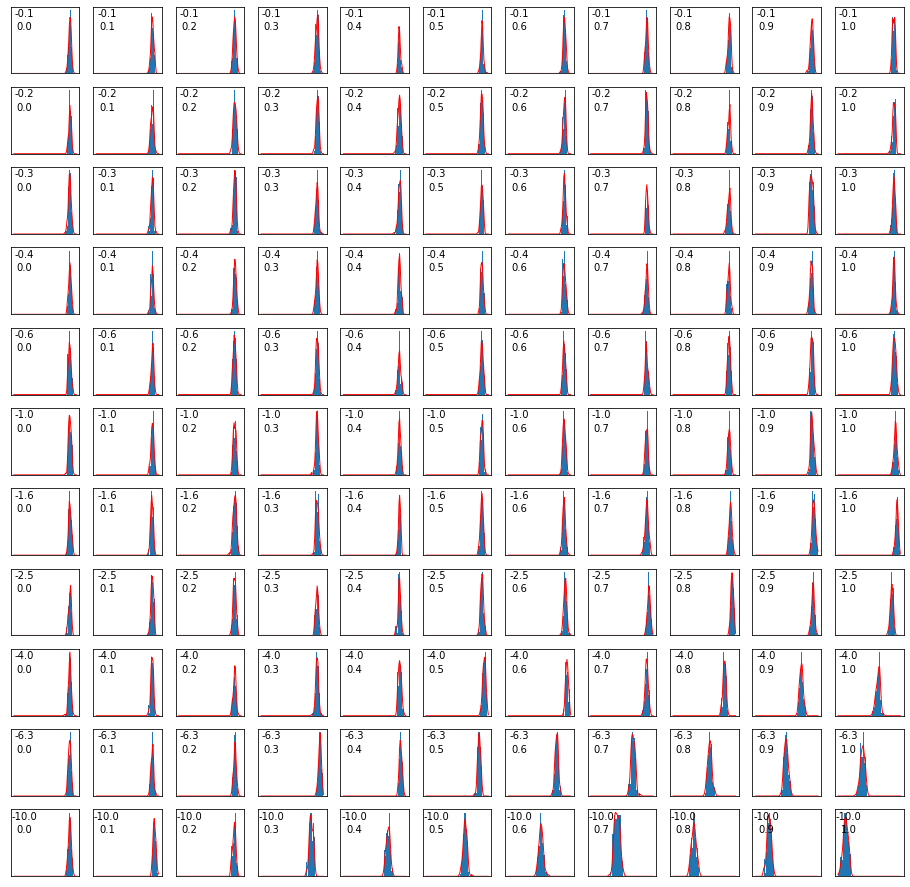

In [116]:
plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 10
nparams = 2
draws = 50
logLs = df_ten_billion.logLs_nonzero9
lams = df_ten_billion.lams_nonzero9
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
bs = df_billion.bs
ms = ms_corrected
peak_logLs = []
mean_logLs = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        # top text is timescale for going from P(intact)=1 to P(intact)=0
        ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        peak_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
        
#plt.savefig('logLs.eps', format='eps')
plt.show()

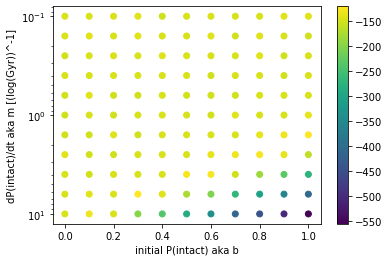

In [117]:
plt.scatter(bs, [-1*m for m in ms_corrected], c=peak_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [(log(Gyr))^-1]')
plt.gca().invert_yaxis()
#plt.yscale('symlog', linthreshy=10)
plt.yscale('log')
plt.colorbar()
plt.show()

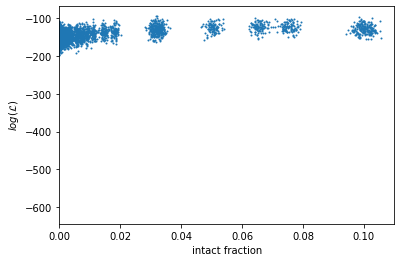

In [137]:
plt.scatter(df_ten_billion.intact_fracs.explode(), df_ten_billion.logLs_nonzero9.explode(), s=1)
plt.ylabel(r'$log(\mathcal{L})$')
plt.xlabel('intact fraction')
plt.xlim(0., 0.11)
#plt.ylim(-100, -30)
#plt.savefig('logLs_v_intacts_nonbinned.eps', format='eps')
plt.show()

In [153]:
df_exploded = df_ten_billion.apply(pd.Series.explode) # looks like it doesn't do so correctly for geometric cols but does't matter
df_exploded1 = df_exploded.loc[(df_exploded.logLs_nonzero9 > -460) & (df_exploded.intact_fracs > 0.025) 
                             & (df_exploded.intact_fracs < 0.04)]
print(np.mean(0.8*df_exploded1.intact_fracs), np.mean(df_exploded1.logLs_nonzero9))
print(len(df_exploded1)) # good, at least all three models that fall in this clump do so entirely
print(np.min(df_exploded1.logLs_nonzero9))

0.025652160849316433 -128.89161845767137
300
-162.7494168114563


[599.2, 67.2, 13.600000000000001, 7.2, 3.2] [488.0, 29.6, 0.8, 0.0, 0.0] [549.9920000000001, 45.858666666666664, 5.184000000000001, 2.533333333333333, 0.736]


[]

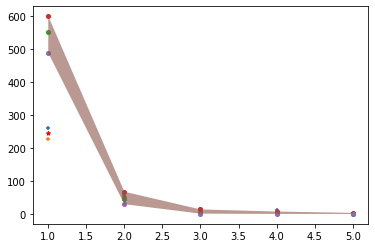

In [139]:
lam_upper = []
lam_lower = []
lam_avgs = []
lams_nonzero = [ln for ln in df_exploded1.lams_nonzero9]
for temp_list in zip_longest(*lams_nonzero):
    #elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
    lam_upper.append(max(temp_list))
    lam_lower.append(min(temp_list))
    lam_avgs.append(np.mean(temp_list))
print(lam_upper, lam_lower, lam_avgs)

plt.scatter(np.arange(6)[1:], nonzero_k, marker=(5, 1), color='r', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k+np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k-np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], lam_avgs, s=16)
plt.scatter(np.arange(6)[1:], lam_upper, s=16)
plt.scatter(np.arange(6)[1:], lam_lower, s=16)
plt.fill_between(np.arange(6)[1:], lam_lower, lam_upper, alpha=0.6)
plt.plot()

#### Scaling of 0.9

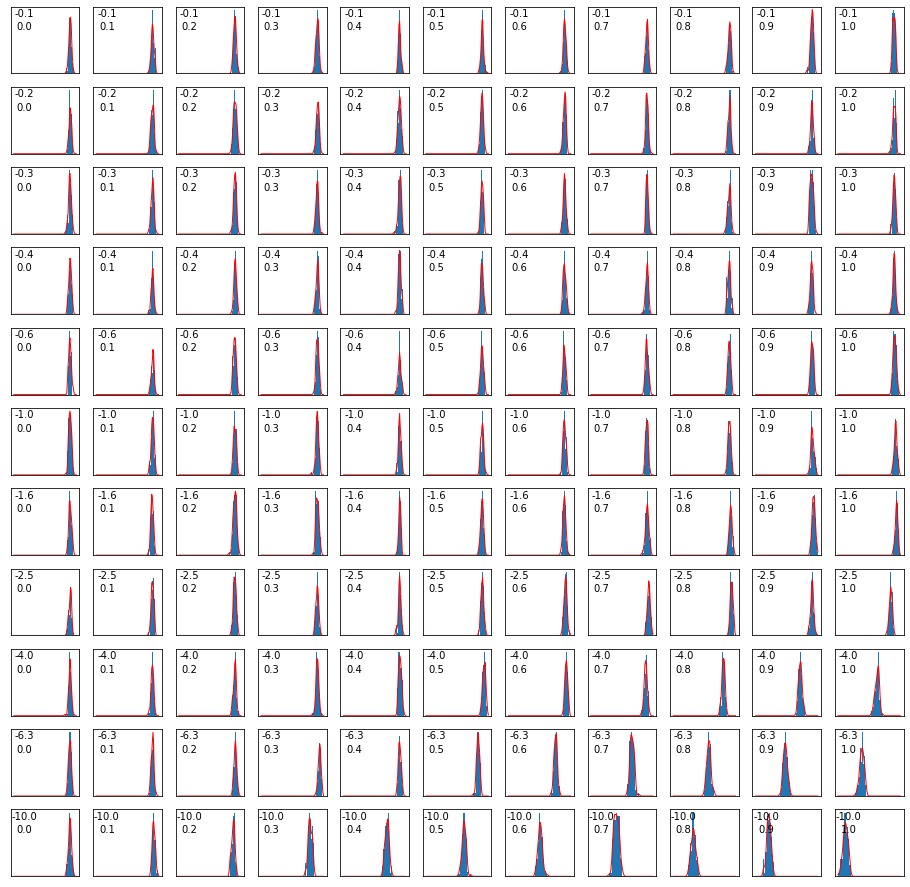

In [140]:
plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 10
nparams = 2
draws = 50
logLs = df_ten_billion.logLs_nonzero10
lams = df_ten_billion.lams_nonzero10
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
bs = df_billion.bs
ms = ms_corrected
peak_logLs = []
mean_logLs = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        # top text is timescale for going from P(intact)=1 to P(intact)=0
        ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        peak_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
        
#plt.savefig('logLs.eps', format='eps')
plt.show()

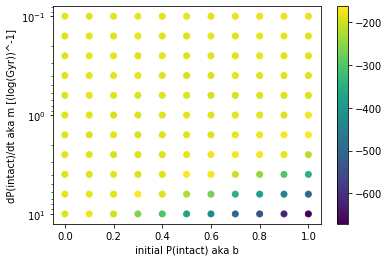

In [141]:
plt.scatter(bs, [-1*m for m in ms_corrected], c=peak_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [(log(Gyr))^-1]')
plt.gca().invert_yaxis()
#plt.yscale('symlog', linthreshy=10)
plt.yscale('log')
plt.colorbar()
plt.show()

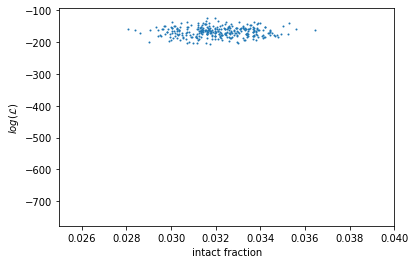

In [159]:
plt.scatter(df_ten_billion.intact_fracs.explode(), df_ten_billion.logLs_nonzero10.explode(), s=1)
plt.ylabel(r'$log(\mathcal{L})$')
plt.xlabel('intact fraction')
plt.xlim(0.025, 0.04)
#plt.ylim(-100, -30)
#plt.savefig('logLs_v_intacts_nonbinned.eps', format='eps')
plt.show()

In [152]:
print(np.argmax(df_ten_billion.logLs_nonzero10.explode()))
print(df_ten_billion.intact_fracs.explode().reset_index().intact_fracs[8403])

8403
0.031598978416545645


In [160]:
df_exploded = df_ten_billion.apply(pd.Series.explode) # looks like it doesn't do so correctly for geometric cols but does't matter
df_exploded1 = df_exploded.loc[(df_exploded.logLs_nonzero10 > -460) & (df_exploded.intact_fracs > 0.025) 
                             & (df_exploded.intact_fracs < 0.04)]
print(np.mean(0.9*df_exploded1.intact_fracs), np.mean(df_exploded1.logLs_nonzero9))
print(len(df_exploded1)) # good, at least all three models that fall in this clump do so entirely
print(np.min(df_exploded1.logLs_nonzero10))

0.02885868095548099 -128.89161845767137
300
-205.22997754403917


[674.1, 75.60000000000001, 15.3, 8.1, 3.6] [549.0, 33.300000000000004, 0.9, 0.0, 0.0] [618.7410000000001, 51.59100000000001, 5.832000000000001, 2.85, 0.8280000000000001]


[]

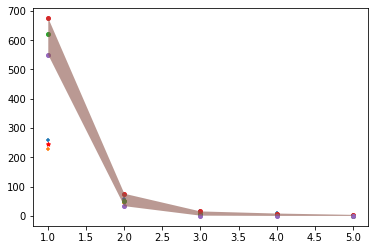

In [163]:
lam_upper = []
lam_lower = []
lam_avgs = []
lams_nonzero = [ln for ln in df_exploded1.lams_nonzero10]
for temp_list in zip_longest(*lams_nonzero):
    #elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
    lam_upper.append(max(temp_list))
    lam_lower.append(min(temp_list))
    lam_avgs.append(np.mean(temp_list))
print(lam_upper, lam_lower, lam_avgs)

plt.scatter(np.arange(6)[1:], nonzero_k, marker=(5, 1), color='r', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k+np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k-np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], lam_avgs, s=16)
plt.scatter(np.arange(6)[1:], lam_upper, s=16)
plt.scatter(np.arange(6)[1:], lam_lower, s=16)
plt.fill_between(np.arange(6)[1:], lam_lower, lam_upper, alpha=0.6)
plt.plot()

#### Scaling of 1.0

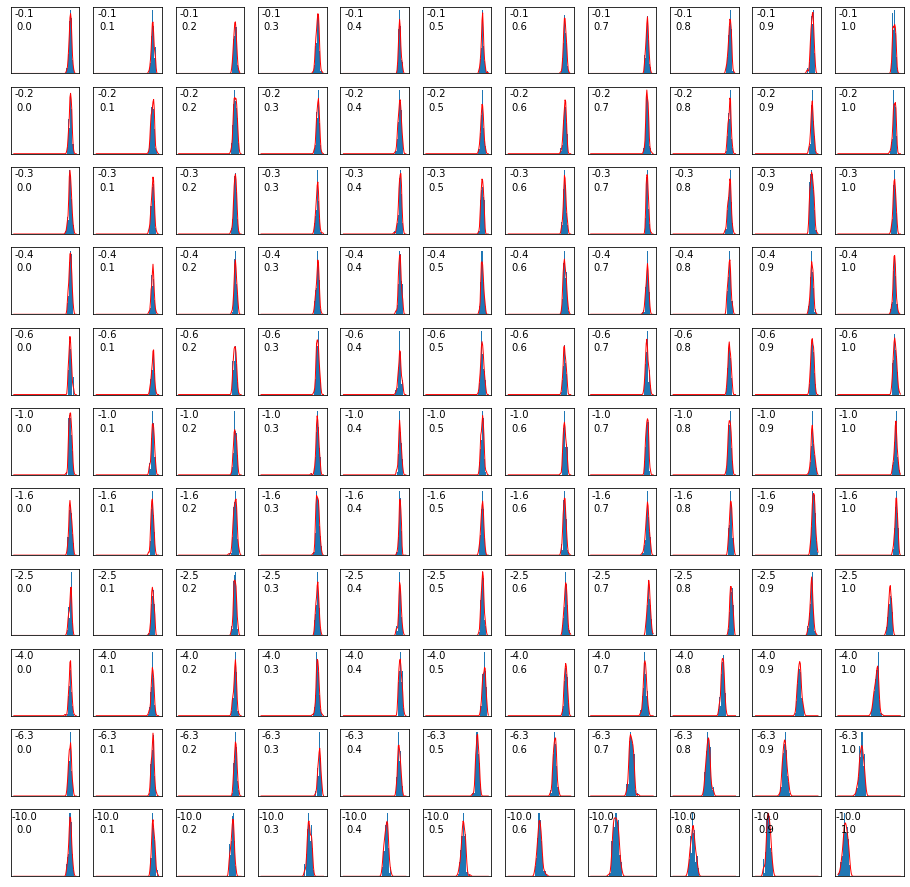

In [164]:
plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 10
nparams = 2
draws = 50
logLs = df_ten_billion.logLs_nonzero11
lams = df_ten_billion.lams_nonzero11
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
bs = df_billion.bs
ms = ms_corrected
peak_logLs = []
mean_logLs = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        # top text is timescale for going from P(intact)=1 to P(intact)=0
        ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        peak_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
        
#plt.savefig('logLs.eps', format='eps')
plt.show()

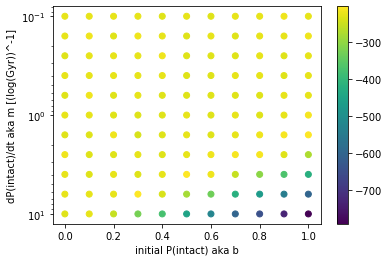

In [165]:
plt.scatter(bs, [-1*m for m in ms_corrected], c=peak_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [(log(Gyr))^-1]')
plt.gca().invert_yaxis()
#plt.yscale('symlog', linthreshy=10)
plt.yscale('log')
plt.colorbar()
plt.show()

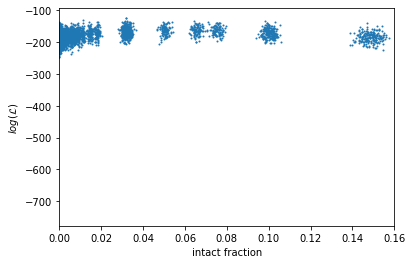

In [169]:
plt.scatter(df_ten_billion.intact_fracs.explode(), df_ten_billion.logLs_nonzero10.explode(), s=1)
plt.ylabel(r'$log(\mathcal{L})$')
plt.xlabel('intact fraction')
plt.xlim(0., 0.16)
#plt.ylim(-100, -30)
#plt.savefig('logLs_v_intacts_nonbinned.eps', format='eps')
plt.show()

In [170]:
print(np.argmax(df_ten_billion.logLs_nonzero11.explode()))
print(df_ten_billion.intact_fracs.explode().reset_index().intact_fracs[8403])

8403
0.031598978416545645


In [171]:
df_exploded = df_ten_billion.apply(pd.Series.explode) # looks like it doesn't do so correctly for geometric cols but does't matter
df_exploded1 = df_exploded.loc[(df_exploded.logLs_nonzero11 > -460) & (df_exploded.intact_fracs > 0.025) 
                             & (df_exploded.intact_fracs < 0.04)]
print(np.mean(1.*df_exploded1.intact_fracs), np.mean(df_exploded1.logLs_nonzero11))
print(len(df_exploded1)) # good, at least all three models that fall in this clump do so entirely
print(np.min(df_exploded1.logLs_nonzero11))

0.03206520106164553 -209.64020920180963
300
-251.63605459616613


[749.0, 84.0, 17.0, 9.0, 4.0] [610.0, 37.0, 1.0, 0.0, 0.0] [687.49, 57.32333333333333, 6.48, 3.1666666666666665, 0.92]


[]

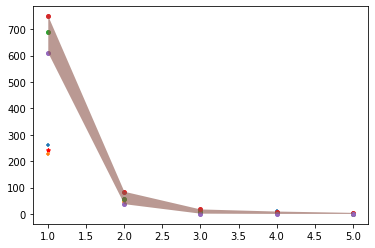

In [172]:
lam_upper = []
lam_lower = []
lam_avgs = []
lams_nonzero = [ln for ln in df_exploded1.lams_nonzero11]
for temp_list in zip_longest(*lams_nonzero):
    #elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
    lam_upper.append(max(temp_list))
    lam_lower.append(min(temp_list))
    lam_avgs.append(np.mean(temp_list))
print(lam_upper, lam_lower, lam_avgs)

plt.scatter(np.arange(6)[1:], nonzero_k, marker=(5, 1), color='r', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k+np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], nonzero_k-np.sqrt(nonzero_k), marker='+', s=16)
plt.scatter(np.arange(6)[1:], lam_avgs, s=16)
plt.scatter(np.arange(6)[1:], lam_upper, s=16)
plt.scatter(np.arange(6)[1:], lam_lower, s=16)
plt.fill_between(np.arange(6)[1:], lam_lower, lam_upper, alpha=0.6)
plt.plot()

#### Scaling of 0.0

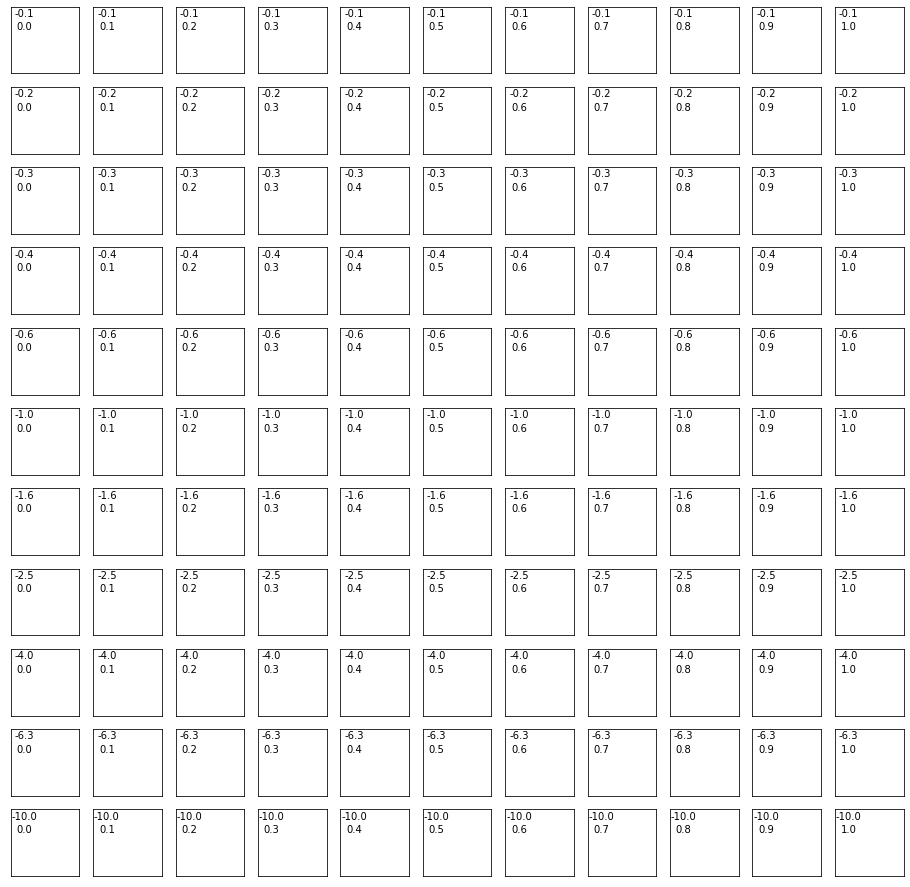

In [174]:
plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 10
nparams = 2
draws = 50
logLs = df_ten_billion.logLs_nonzero1
lams = df_ten_billion.lams_nonzero1
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
bs = df_billion.bs
ms = ms_corrected
peak_logLs = []
mean_logLs = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        # top text is timescale for going from P(intact)=1 to P(intact)=0
        ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        peak_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
        
#plt.savefig('logLs.eps', format='eps')
plt.show()

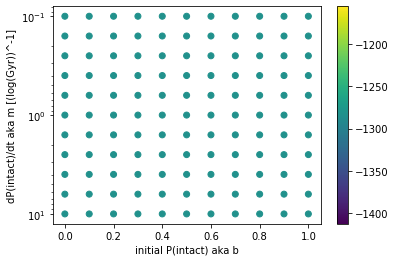

In [175]:
plt.scatter(bs, [-1*m for m in ms_corrected], c=peak_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [(log(Gyr))^-1]')
plt.gca().invert_yaxis()
#plt.yscale('symlog', linthreshy=10)
plt.yscale('log')
plt.colorbar()
plt.show()

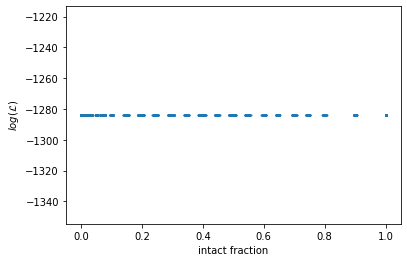

In [176]:
plt.scatter(df_ten_billion.intact_fracs.explode(), df_ten_billion.logLs_nonzero1.explode(), s=1)
plt.ylabel(r'$log(\mathcal{L})$')
plt.xlabel('intact fraction')
#plt.xlim(0., 0.16)
#plt.ylim(-100, -30)
#plt.savefig('logLs_v_intacts_nonbinned.eps', format='eps')
plt.show()

### Introducing the intact vs disrupted vs logL plot

In [225]:
def calc_disrupted(scaling_factor, intact_frac):
    return scaling_factor*(1-intact_frac)

def calc_intact(scaling_factor, intact_frac):
    return scaling_factor*intact_frac

# for each scaling factor and its associated likeliest intact fraction, there is a corresponding (f_cold, f_hot)
# this means I can plot 11 points and compare them to the plot from Ballard & Moriarity
hotncold = pd.DataFrame()
hotncold['scaling_factor'] = np.linspace(0.1, 1., 10)
hotncold['likeliest_intact_frac'] = [0.08997801592468324, 0.0992281035605188, 0.08885199559316942, 0.07828273824427862, 
                        0.0741872402223446, 0.06009750112674646, 0.07011375131453754, 0.025652160849316433,
                        0.02885868095548099, 0.03206520106164553]

hotncold['disrupteds'] = calc_disrupted(hotncold.scaling_factor, hotncold.likeliest_intact_frac)
hotncold['intacts'] = calc_intact(scaling_factor, likeliest_intact_frac)
hotncold['best_logLs'] = [max(df_exploded.logLs_nonzero2), max(df_exploded.logLs_nonzero3),
                          max(df_exploded.logLs_nonzero4), max(df_exploded.logLs_nonzero5),
                          max(df_exploded.logLs_nonzero6), max(df_exploded.logLs_nonzero7),
                          max(df_exploded.logLs_nonzero8), max(df_exploded.logLs_nonzero9),
                          max(df_exploded.logLs_nonzero10), max(df_exploded.logLs_nonzero11)]
print(hotncold)


   scaling_factor  likeliest_intact_frac  disrupteds   intacts  best_logLs
0             0.1               0.089978    0.091002  0.008998 -116.296317
1             0.2               0.099228    0.180154  0.019846  -34.866663
2             0.3               0.088852    0.273344  0.026656  -13.109906
3             0.4               0.078283    0.368687  0.031313  -12.708956
4             0.5               0.074187    0.462906  0.037094  -21.190555
5             0.6               0.060098    0.563941  0.036059  -39.476943
6             0.7               0.070114    0.650920  0.049080  -64.962638
7             0.8               0.025652    0.779478  0.020522  -94.052729
8             0.9               0.028859    0.874027  0.025973 -124.951072
9             1.0               0.032065    0.967935  0.032065 -159.762510


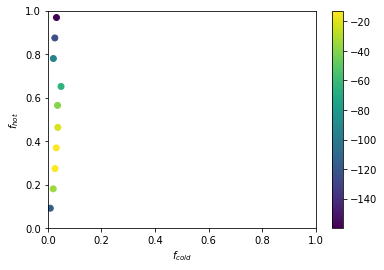

In [221]:
plt.scatter(hotncold.intacts, hotncold.disrupteds, c=hotncold.best_logLs)
plt.xlabel('$f_{cold}$')
plt.ylabel('$f_{hot}$')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.colorbar()
plt.show()

#plt.gca().invert_yaxis()
#plt.yscale('symlog', linthreshy=10)
#plt.yscale('log')

Okay, now we have to do this but not for the peaks of each scaling - rather, we do it for every point in the logL v intact fraction curve. 

In [212]:
pd.concat([df_ten_billion.intact_fracs.explode().reset_index()['intact_fracs'], 
          0.9*df_ten_billion.intact_fracs.explode().reset_index()['intact_fracs']], axis=0)

0          0
1          0
2          0
3          0
4          0
        ... 
12095    0.9
12096    0.9
12097    0.9
12098    0.9
12099    0.9
Name: intact_fracs, Length: 24200, dtype: object

In [223]:
df_ten_billion_logLs = [df_ten_billion.logLs_nonzero1.explode().reset_index().logLs_nonzero1, 
                       df_ten_billion.logLs_nonzero2.explode().reset_index().logLs_nonzero2,
                       df_ten_billion.logLs_nonzero3.explode().reset_index().logLs_nonzero3,
                       df_ten_billion.logLs_nonzero4.explode().reset_index().logLs_nonzero4,
                       df_ten_billion.logLs_nonzero5.explode().reset_index().logLs_nonzero5,
                       df_ten_billion.logLs_nonzero6.explode().reset_index().logLs_nonzero6,
                       df_ten_billion.logLs_nonzero7.explode().reset_index().logLs_nonzero7,
                       df_ten_billion.logLs_nonzero8.explode().reset_index().logLs_nonzero8,
                       df_ten_billion.logLs_nonzero9.explode().reset_index().logLs_nonzero9,
                       df_ten_billion.logLs_nonzero10.explode().reset_index().logLs_nonzero10]

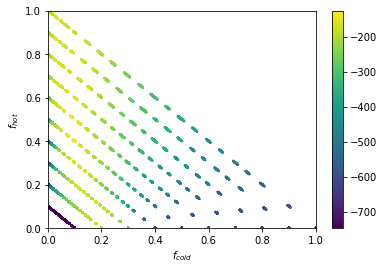

In [232]:
for i in range(10):
    hotncold = pd.DataFrame()
    hotncold['scaling_factor'] = 0.1*(i+1)*np.ones(12100)
    hotncold['pre_scaled_intacts'] = df_ten_billion.intact_fracs.explode().reset_index().intact_fracs
    hotncold['logLs'] = df_ten_billion_logLs[i]
    hotncold['disrupteds'] = calc_disrupted(hotncold.scaling_factor, hotncold.pre_scaled_intacts)
    hotncold['intacts'] = calc_intact(hotncold.scaling_factor, hotncold.pre_scaled_intacts)
    plt.scatter(hotncold.intacts, hotncold.disrupteds, c=hotncold.logLs, s=2)

plt.xlabel('$f_{cold}$')
plt.ylabel('$f_{hot}$')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.colorbar()
plt.show()
    